# Increasing mitochondrial mutational load with age

We use single-cell RNA-sequencing data from Enge et al. to demonstrate that the mitochondrial load is increasing with age.


In [7]:
# load libraries for analysis and plotting

import numpy as np
import pandas as pd
import scanpy as sc
import os
import argparse
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# set seaborn plotting options (not mandatory)
sns.set(font_scale=1.2) 
sns.set_context("paper")
sns.set_style("ticks")

First, we load the data.

In [8]:
# Load the dataframe with mutation information
varianceData = pkl.load( open( "./../../data/precomputedData/Enge/engeVariantsSTAR200.pkl", "rb" ) )
# expression matrix
adata = sc.read_h5ad("./../../data/precomputedData/Enge/engeFilteredExpression200.h5ad")
# metadata
metadata = pkl.load( open( "./../../data/precomputedData/Enge/enge_metadata.pkl", "rb" ) )

In [9]:
# add age and cell type as annotations to the expression matrix 
# get all ages from the variance data
age = [ metadata[metadata['SRR_id'] == item]['donor_age'].iloc[0] if (item in metadata['SRR_id'].values) else 0 for item in adata.obs_names]
# add it to the expression matrix
adata.obs['donor_age'] = age
# cellType = [ metadata[metadata['SRR_id'] == item]['inferred_cell_type'].iloc[0] if (item in metadata['SRR_id'].values) else 0 for item in adata.obs_names]
# adata.obs['cell_type'] = cellType

These are functions that take the gene expression matrix and the dataframe with the mutation information to compute the mitochondrial load and identify differentially expressed genes.

In [10]:
# define a function that computes mitochondrial load and adds it to the data frame
def computeMitochondrialLoad(expressionMatrix,varianceDataFrame,
                             threshold = 0.05, #threshold: heteroplasmy threshold (only mutations above this threshold are considered)
                             mutantType = 'all', # which type of mutations should be considered, list of strings, e.g., ['Common mutation','Developmental']
                             removeSynonymous = 0, # whether to remove synonymous mutations from the mutations
                             pathologyType = 'all', # which type of pathology we look at
                             subsetCells = 'all', # whether to keep only certain type of cells
                             rescaling= False, # rescaling by considering the number of bases passed (not recommended)
                             muName = 'MU' # name given to the mitochondrial load in the expression matrix Anndata object
                            ): 
    
    # Apply heteroplasmy threshold 
    varianceDataFrame = varianceDataFrame[threshold<varianceDataFrame['HF']]
    
    # Keep only certain type of mutations
    if (mutantType == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['mutant_type'].isin(mutantType)]
    
    # Keep only synonomous or non-synonomous mutation
    if removeSynonymous == True:
        varianceDataFrame= varianceDataFrame[~(varianceDataFrame['MutPred_Prediction'] == 'Synonymous')]
    elif (removeSynonymous == -1):
        # keep only synonomous mutations
        varianceDataFrame= varianceDataFrame[(varianceDataFrame['MutPred_Prediction'] == 'Synonymous')]
    
    # Keep only mutations of a certain pathology
    if (pathologyType == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['MutPred_Prediction'].isin(pathologyType)]
    
    # Keep only certain cells
    if (subsetCells == 'all'):
        pass
    else:
        # keep only variance which is in this list
         varianceDataFrame = varianceDataFrame[varianceDataFrame['sample_id'].isin(subsetCells)]
    
    # optional rescaling (it is easier to do this before the summation and the math works out)
    if (rescaling == True):
        varianceDataFrame['scalingFactor'] = 16569/varianceDataFrame['bases_passed']
        varianceDataFrame['HF'] = varianceDataFrame.HF * varianceDataFrame.scalingFactor
        

    # compute the mitochondrial load
    groupedData = varianceDataFrame.groupby('sample_id') # group for each cell
    mu = groupedData.sum()['HF'] # mitochondrial load is then the sum over the heteroplasmies
    
    
    # add the mitoLoad as observable MU annotation
    expressionMatrix.obs[muName] = mu
    expressionMatrix.obs[muName] = expressionMatrix.obs[muName] .fillna(0)
    
    return(expressionMatrix)

In [11]:
# We only want mutations that could be detected in at least 10 cells (based on the depth threshold), such that we don't wrongly identify cryptic mutations.
# In practice, changing this threshold or removing this step totally doesn't change the results dramatically.
varianceSubset = varianceData[varianceData['cells_possible']>10]

## Plots
We now compute and plot the mitochondrial load $\mu$ for all eight donors for four different heteroplasmy thresholds. Later, we demonstrate that the correlation between donor age $t$ and the mitochondrial load $\mu$ for all heteroplasmy threhsolds.

In [6]:
# define a function that does all the plotting
def plotMuVersusDonorAge(geneExpressionData, mutationData,heteroplasmyThreshold,saveFig=None):
    # 1) compute mitochondrial load
    adataMu = computeMitochondrialLoad(geneExpressionData,mutationData,threshold=heteroplasmyThreshold,removeSynonymous=1,mutantType=['Cryptic'],rescaling=False)
    
    # 2) save it in a data frame for plotting
    plotData = pd.DataFrame()
    plotData['age'] = adataMu.obs['donor_age']
    plotData['MU'] = adataMu.obs['MU'] # mitochondrial load
    
    # 3) get the standard deviation for each age
    unqiueAges = np.sort(plotData['age'].unique())
    stdAge =[]
    for age in np.sort(plotData['age'].unique()):
        stdAge.append(np.std(plotData[plotData['age']==age])['MU'])
        
    # 4) Plotting
    fig, ax = plt.subplots(figsize=(8,8))
    # a) Striplot which shows each cell
    g = sns.stripplot(x="age", y="MU", data=plotData,color=".5",jitter=0.3,palette=sns.xkcd_palette(["grey"]),ax=ax)

    # axis labels
    
    heteroplasmyThresholdString = str(int(heteroplasmyThreshold*100))
    #heteroplasmyThreshold = "%2.2f" % heteroplasmyThreshold*100
    plt.xlabel('age, t [years]')
    plt.ylabel(r'mitochondrial load, $\mu_{\mathrm{c,NS}}^{' + heteroplasmyThresholdString+ '\,\%}$')

    # b) plot the standard deviation as star
    ax2 =ax.twinx()
    secondColour = sns.xkcd_rgb["blue"]
    ax2.scatter(x=np.arange(0,8,1),y=stdAge,c=secondColour,marker='*',s=100)
    ax2.set_ylabel(r'standard deviation mitochondrial load, $\sigma (\mu_{\mathrm{c,NS}}^{' + heteroplasmyThresholdString+ '\,\%}$')
    ax2.yaxis.label.set_color(secondColour)
    ax2.spines['right'].set_color(secondColour)
    tkw = dict(size=4, width=1.5)
    ax2.tick_params(axis='y', colors=secondColour, **tkw)
    ax2.set_ylim(0, 1)
    # add labels
    g.set(xticklabels=['1/12',5,6,21,22,38,44,54
                  ])
    plt.title(r'heteroplasmy threshold, $h=' + heteroplasmyThresholdString + '\,\%$')
    
    
    # 5) Compute the correlations and display them
    pearsonr = stats.pearsonr(plotData['age'],plotData['MU'])
    spearmanr = stats.spearmanr(plotData['age'],plotData['MU'])
    
    print(pearsonr)
    print(spearmanr)

    # 6) save the figure, if wanted
    if saveFig is not None:
        plt.savefig(saveFig)



## 10% threshold

(0.15066693967622938, 2.0811735819962216e-13)
SpearmanrResult(correlation=0.04076217131250186, pvalue=0.048130978766036316)


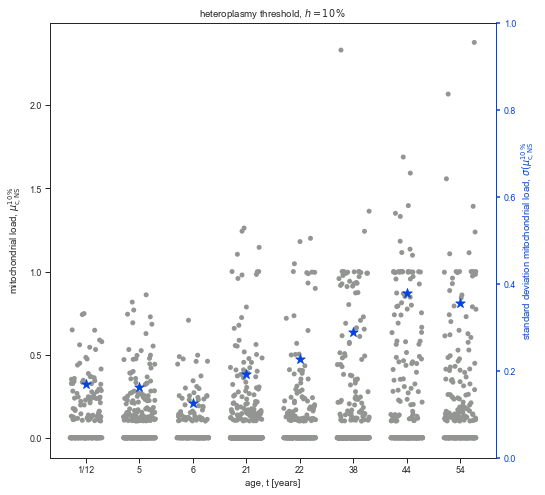

In [7]:

plotMuVersusDonorAge(adata, varianceSubset,heteroplasmyThreshold=0.1,saveFig = './../../figures/publicationFigures/mitochondrialLoad/mitochondrialLoadVersusAge_t10.pdf')


## 30% threshold

(0.22200961683421463, 1.2160870495915795e-27)
SpearmanrResult(correlation=0.22022568191193226, pvalue=3.247189941321501e-27)


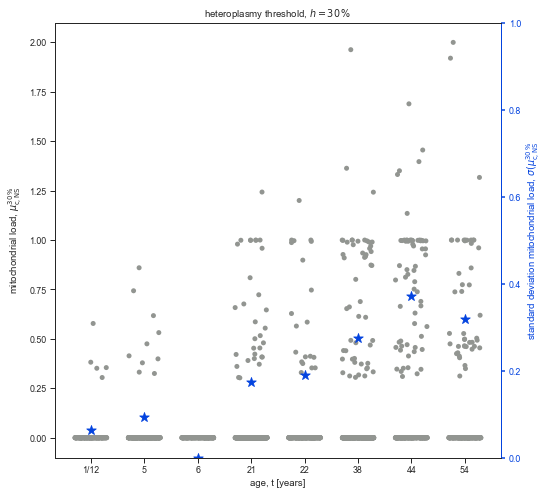

In [8]:
plotMuVersusDonorAge(adata, varianceSubset,heteroplasmyThreshold=0.3,saveFig = './../../figures/publicationFigures/mitochondrialLoad/mitochondrialLoadVersusAge_t30.pdf')


## Threshold 40%

(0.21796207204327625, 1.1152444047173029e-26)
SpearmanrResult(correlation=0.22521727894798765, pvalue=2.0350947405623576e-28)


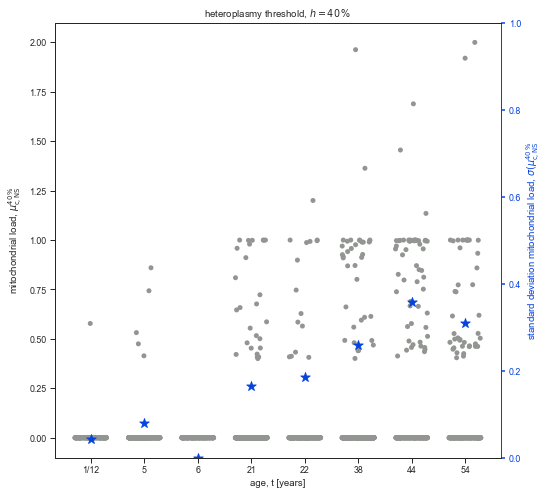

In [9]:
plotMuVersusDonorAge(adata, varianceSubset,heteroplasmyThreshold=0.4,saveFig = './../../figures/publicationFigures/mitochondrialLoad/mitochondrialLoadVersusAge_t40.pdf')


## Threshold 90%

(0.15556625034791158, 3.3205549700353127e-14)
SpearmanrResult(correlation=0.15449513775037604, pvalue=4.9852581106995274e-14)


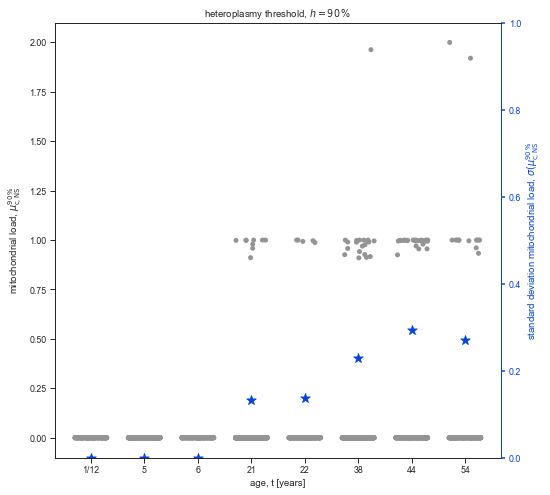

In [10]:
plotMuVersusDonorAge(adata, varianceSubset,heteroplasmyThreshold=0.9,saveFig = './../../figures/publicationFigures/mitochondrialLoad/mitochondrialLoadVersusAge_t90.pdf')


## Vary the threshold



In [11]:
def computeSTDage(dataIn):
    # get mean and std for each age
    unqiueAges = np.sort(dataIn['age'].unique())
    stdAge =[]

    for age in np.sort(dataIn['age'].unique()):
        stdAge.append(np.std(dataIn[dataIn['age']==age])['MU'])
    return(stdAge)

# output lists
pearsonOut = []
spearmanOut = []
spearmanStdOut = []


thresholds= np.arange(0,1,0.01)
# go over each threshold and compute
for t in thresholds:
    adataMu = computeMitochondrialLoad(adata,varianceSubset,threshold=t,removeSynonymous=1,mutantType=['Cryptic'],rescaling=False)
    plotData = pd.DataFrame()
    plotData['age'] = adataMu.obs['donor_age']
    plotData['MU'] = adataMu.obs['MU']
    
    # compute the std
    stdAgeMu = computeSTDage(plotData)
    
    # compute the correlation
    pearsonr = stats.pearsonr(plotData['age'],plotData['MU'])
    pearsonOut.append(pearsonr[1])
    spearmanr = stats.spearmanr(plotData['age'],plotData['MU'])
    spearmanOut.append(spearmanr[1])

    spearmanrStd = stats.spearmanr(np.sort(plotData['age'].unique()),stdAgeMu)
    spearmanStdOut.append(spearmanrStd[1])


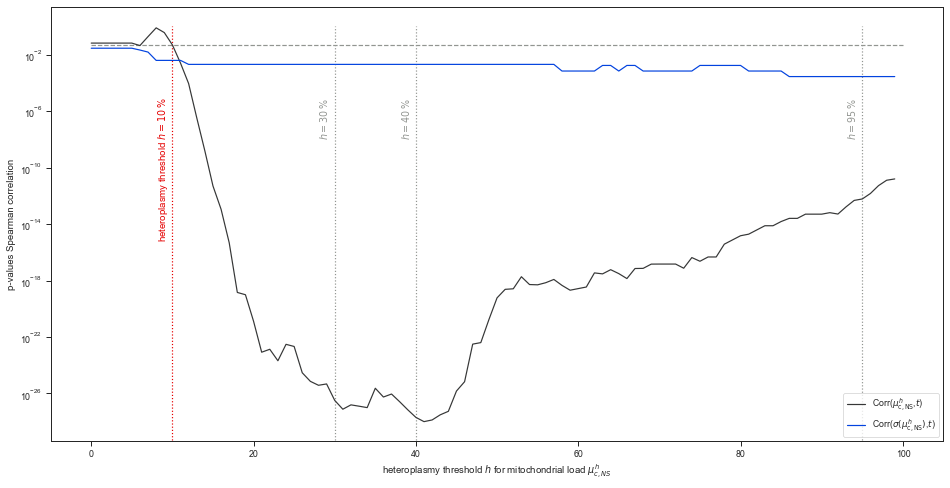

In [12]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(thresholds*100,spearmanOut,label=r'Corr($\mu_{\mathrm{c,NS}}^{h}$,$t$)',color=sns.xkcd_rgb["dark grey"])
plt.plot(thresholds*100,spearmanStdOut,label=r'Corr($\sigma(\mu_{\mathrm{c,NS}}^{h})$,$t$)',color=sns.xkcd_rgb["blue"])

# significnace threshold
plt.hlines(0.05,0,100, linestyles='dashed',color=sns.xkcd_rgb["grey"])



first=True

for x in [10,30,40,95]:
    # first time we are below the significnace threshold is highlighted
    if first:
        labelText = r'heteroplasmy threshold $h='+str(x)+'\,\%$'
        plt.vlines(x,0,1, linestyles='dotted',color=sns.xkcd_rgb["red"])
        plt.text(x-2,10**(-5),labelText,rotation=90,color=sns.xkcd_rgb["red"],va='top')
        
        first=False
    else:
        labelText = r'$h='+str(x)+'\,\%$'
        plt.vlines(x,0,1, linestyles='dotted',color=sns.xkcd_rgb["grey"])
        plt.text(x-2,10**(-5),labelText,rotation=90,color=sns.xkcd_rgb["grey"],va='top')
    
plt.yscale("log")
plt.xlabel(r'heteroplasmy threshold $h$ for mitochondrial load $\mu^h_{c,NS}$')
plt.ylabel(r'p-values Spearman correlation')
plt.legend(loc='lower right')
plt.savefig('./../../figures/publicationFigures/mitochondrialLoad/spearmanCorrelationHvar.pdf')